In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'delete'
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    _,_,v = np.linalg.svd(X,full_matrices=False)
    Y = X@v[:no_dims].T
    #(l, M) = np.linalg.eig(np.dot(X.T, X))
    #Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)
        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        gains = 1
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [11]:
gains = 1
dY = 1
iY = -1

In [12]:
gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
gains

1.2

In [8]:
iY > 0

array([[ True,  True],
       [ True, False],
       [False, False],
       [ True, False],
       [False,  True]])

In [140]:
def my_tsne(X, no_dims=2, initial_dims=50, perplexity=30.0, eta=500, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the mxm array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
    """

    # necessary functions 
    from scipy.spatial import distance
    from numpy.linalg import eig
    def my_pca(X, no_dims=50):
        """
            Runs PCA on the mxn array X in order to reduce its dimensionality to
            no_dims dimensions.
        """
        print("Preprocessing the data using PCA...")
        m, n = X.shape
        X = X - np.mean(X,axis=0) # center X
        _,_,v = np.linalg.svd(X,full_matrices=False)
        Y = X@v[:no_dims].T
        #l, M = eig(np.dot(X.T, X))
        #Y = np.dot(X, M[:, 0:no_dims])
        return Y
    def my_Hbeta(D, beta=1):
        """
            Compute the perplexity and the P-column for a specific value of the
            precision of a Gaussian distribution.
        """
        # Compute P-column and corresponding perplexity
        P = np.exp(-D*beta)
        sumP = np.sum(P)
        perplexity = np.log(sumP) + beta*np.sum(D*P)/sumP
        P = P/sumP
        return perplexity, P
    def my_x2p(X, tol=1e-5, perplexity=30.0):
        """
            Performs a binary search to get P-values in such a way that each
            conditional Gaussian has the same perplexity.
        """

        # Initialize some variables
        print("Computing pairwise distances...")
        m,n = X.shape
        # compute all pairwise distances
        D = np.square(distance.squareform(distance.pdist(X)))
        # initialize variables
        P = np.zeros((m, m))
        beta = np.ones((m, 1))
        logU = np.log(perplexity)
        # Compute P matrix
        for i in range(m):
            betamin = -np.inf
            betamax = np.inf
            
            # Print progress
            if i % 500 == 0:
                print("Computing P-values for point %d of %d..." % (i, m))
                
            # Compute the Gaussian kernel and entropy for the current precision
            idx = np.concatenate((range(0,i),range(i+1,m))).astype('int')
            Di = D[idx,i] 
            Perplexity,P_column = my_Hbeta(Di, beta[i])
            # Evaluate whether the perplexity is within tolerance
            PerplexityDiff = Perplexity - logU
            tries = 0
            # Perform a binary search
            while np.abs(PerplexityDiff) > tol and tries < 50:
                if PerplexityDiff > 0:
                    betamin = beta[i].copy()
                    if betamax == np.inf: # or betamax == -np.inf:
                        beta[i] = beta[i] * 2.
                    else:
                        beta[i] = (beta[i] + betamax) / 2.
                else:
                    betamax = beta[i].copy()
                    if betamin == -np.inf: #betamin == np.inf or betamin == -np.inf:
                        beta[i] = beta[i] / 2.
                    else:
                        beta[i] = (beta[i] + betamin) / 2.               
                # Recompute perplexiy
                Perplexity, P_column = my_Hbeta(Di, beta[i])
                PerplexityDiff = Perplexity - logU
                tries += 1
            # Set the final column of P
            P[idx,i] = P_column
        # Return final P-matrix
        print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
        return P
    
    #################### MAIN FUNCTION ##################
    m,n = X.shape
    # Perform PCA
    X = my_pca(X, initial_dims)
    # Gradient Descent with Momentum parameters
    #max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    #eta = 500
    min_gain = 0.01 
    # Initialize variables
    Y = np.random.randn(m, no_dims)
    dY = np.zeros((m, no_dims)) # gradient
    iY = np.zeros((m, no_dims)) 
    gains = np.ones((m, no_dims)) 
    
    # Compute P matrix
    P = my_x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4
    P = np.maximum(P, 1e-12)
    
    # Gradient Descent
    for iter in range(max_iter):
        # Compute pairwise affinities qij
        # NEW
        DY = np.square(distance.squareform(distance.pdist(Y)))
        num = 1/(1+DY)
        np.fill_diagonal(num, 0) #set diagonal entries of num to 0
        Q = num/np.sum(num) # normalize 
        Q = np.maximum(Q, 1e-12)
        # OLD
        #DY = np.square(distance.squareform(distance.pdist(Y)))
        #Q = np.exp(-DY)
        #np.fill_diagonal(Q, 0) #set diagonal entries of Q to 0
        #Q = Q/np.sum(Q,axis=0) # normalize columns


        # Compute gradient
        PminusQ = P - Q     
        # NEW
        for i in range(m):
            dY[i] = 4*(PminusQ[:, i] * num[:, i])@(Y[i]-Y)
        # OLD
        #for i in range(m):
        #    gradient[i] = 2*(PminusQ[i]+PminusQ[:,i])@(Y[i]-Y)

        
        #Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        
        iY = momentum * iY - eta * (gains * dY)
        #iY = momentum*iY-eta*gradient
        Y = Y + iY
        Y = Y - np.mean(Y,axis=0)
        
        #Y = Y - eta*gradient2
        #Y = Y - np.mean(Y,axis=0)
        


        # Compute current value of cost function
        if (iter + 1) % 100 == 0:
            cost = np.sum(P * np.log(P / Q))
           # cost = np.sum([P[i,j]*np.log(P[i,j]/Q[i,j]) for i in range(m) for j in range(m) if j!=i])
            print("Iteration %d: error is %f" % (iter + 1, cost))
            
        if iter == 100:
            P = P / 4.
    # Return solution and cost function
    return Y

In [152]:
X = np.zeros((20,3))
X[:10] = np.random.randn(10,3)
X[10:] = np.random.randn(10,3)+[10,10,10]

In [203]:
'Obtain the MNist dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
X,y=mnist['data'],mnist['target']
X = X[:3000]

In [204]:
y = y[:3000]

In [205]:
y = y.astype(np.uint8)

In [206]:
X = X/255

In [207]:
new_X = tsne(X, no_dims=2, initial_dims=50, perplexity=20)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 3000...
Computing P-values for point 500 of 3000...
Computing P-values for point 1000 of 3000...
Computing P-values for point 1500 of 3000...
Computing P-values for point 2000 of 3000...
Computing P-values for point 2500 of 3000...
Mean value of sigma: 2.030888
Iteration 100: error is 17.872560
Iteration 200: error is 2.289712
Iteration 300: error is 2.056969
Iteration 400: error is 1.928086
Iteration 500: error is 1.841515
Iteration 600: error is 1.777546
Iteration 700: error is 1.727485
Iteration 800: error is 1.686783
Iteration 900: error is 1.652763
Iteration 1000: error is 1.623705


In [213]:
my_new_X = my_tsne(X, no_dims=2, initial_dims=50, perplexity=20)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 3000...
Computing P-values for point 500 of 3000...
Computing P-values for point 1000 of 3000...
Computing P-values for point 1500 of 3000...
Computing P-values for point 2000 of 3000...
Computing P-values for point 2500 of 3000...
Mean value of sigma: 2.030888
Iteration 100: error is 16.736341
Iteration 200: error is 1.373527
Iteration 300: error is 1.232334
Iteration 400: error is 1.177906
Iteration 500: error is 1.148972
Iteration 600: error is 1.131401
Iteration 700: error is 1.119681
Iteration 800: error is 1.111383
Iteration 900: error is 1.105080
Iteration 1000: error is 1.100335


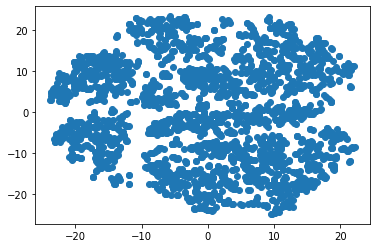

In [209]:
plt.scatter(new_X[:,0],new_X[:,1])

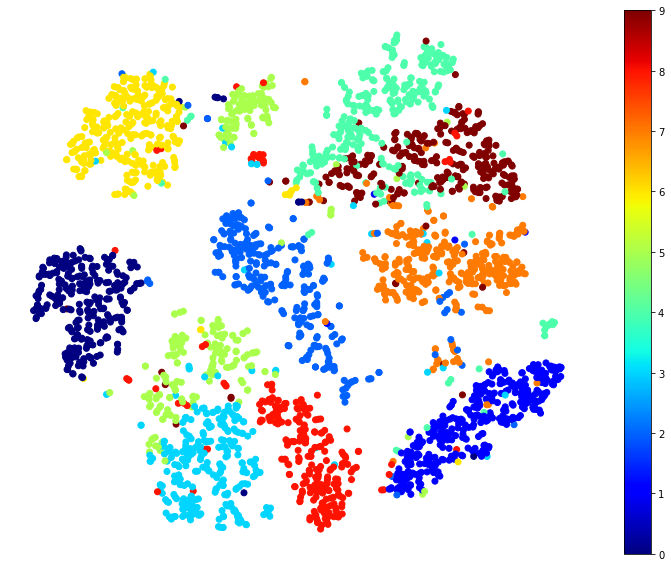

In [214]:
plt.figure(figsize=(13,10))
plt.scatter(my_new_X[:, 0], my_new_X[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# Example 2

In [6]:
import pandas as pd

In [103]:
url1 = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/14cancer.xtrain'
url2 = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/14cancer.xtest'

data_train = pd.read_csv(url1,sep = '\s+',header = None)
data_train = data_train.T

data_test = pd.read_csv(url2,sep = '\s+',header = None)
data_test = data_test.T

data = pd.concat([data_train,data_test])

data.head(5) #show first 10 rows of data_train

,0,1,2,3,4,5,6,7,8,9,...,16053,16054,16055,16056,16057,16058,16059,16060,16061,16062
0,-73.0,-69.0,-48.0,13.0,-86.0,-147.0,-65.0,-71.0,-32.0,100.0,...,-134.0,352.0,-67.0,121.0,-5.0,-11.0,-21.0,-41.0,-967.0,-120.0
1,-16.0,-63.0,-97.0,-42.0,-91.0,-164.0,-53.0,-77.0,-17.0,122.0,...,-51.0,244.0,-15.0,119.0,-32.0,4.0,-14.0,-28.0,-205.0,-31.0
2,4.0,-45.0,-112.0,-25.0,-85.0,-127.0,56.0,-110.0,81.0,41.0,...,14.0,163.0,-14.0,7.0,15.0,-8.0,-104.0,-36.0,-245.0,34.0
3,-31.0,-110.0,-20.0,-50.0,-115.0,-113.0,-17.0,-40.0,-17.0,80.0,...,26.0,625.0,18.0,59.0,-10.0,32.0,-2.0,10.0,-495.0,-37.0
4,-33.0,-39.0,-45.0,14.0,-56.0,-106.0,73.0,-34.0,18.0,64.0,...,-69.0,398.0,38.0,215.0,-2.0,44.0,3.0,68.0,-293.0,-34.0


In [104]:
url1 = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/14cancerlabels.ytrain'
url2 = 'https://raw.githubusercontent.com/um-perez-alvaro/lin-regress/master/14cancer.ytest'

labels_train = pd.read_csv(url1,sep='\s+',header = None)
labels_train = labels_train.T

labels_test = pd.read_csv(url2,sep='\s+',header = None)
labels_test = labels_test.T

labels = pd.concat([labels_train,labels_test])

labels.head(5)

,0
0,1
1,1
2,1
3,1
4,1


In [127]:
X = data.to_numpy()
y = labels.to_numpy()

In [128]:
y_leuk = np.zeros(len(y))
y_leuk[y.flatten()==9]=1

In [129]:
X

array([[  -73.,   -69.,   -48., ...,   -41.,  -967.,  -120.],
       [  -16.,   -63.,   -97., ...,   -28.,  -205.,   -31.],
       [    4.,   -45.,  -112., ...,   -36.,  -245.,    34.],
       ...,
       [ -151., -1160.,  -233., ...,    53., -2058.,   -48.],
       [ -124.,  -231.,   -47., ...,   136., -2222.,   -23.],
       [   17.,  -109.,   -87., ...,   -52.,  -297.,   -87.]])

In [130]:
X = X/np.max(np.abs(X))
X.shape

(198, 16063)

In [131]:
np.min(np.abs(X))

0.0

In [147]:
new_X = my_tsne(X, no_dims=2, initial_dims=144, perplexity=10, eta=500, max_iter = 3000)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 198...
Mean value of sigma: 0.793855
Iteration 100: error is 14.787775
Iteration 200: error is 1.867924
Iteration 300: error is 1.441392
Iteration 400: error is 1.496668
Iteration 500: error is 1.340480
Iteration 600: error is 1.466833
Iteration 700: error is 1.658965
Iteration 800: error is 1.390193
Iteration 900: error is 1.339604
Iteration 1000: error is 1.158336
Iteration 1100: error is 1.079484
Iteration 1200: error is 0.953937
Iteration 1300: error is 0.913251
Iteration 1400: error is 0.855365
Iteration 1500: error is 0.827631
Iteration 1600: error is 0.802215
Iteration 1700: error is 0.754922
Iteration 1800: error is 0.685327
Iteration 1900: error is 0.636747
Iteration 2000: error is 0.587597
Iteration 2100: error is 0.540055
Iteration 2200: error is 0.528081
Iteration 2300: error is 0.500853
Iteration 2400: error is 0.499879
Iteration 2500: error is 0.499168
Iteration 2600: err

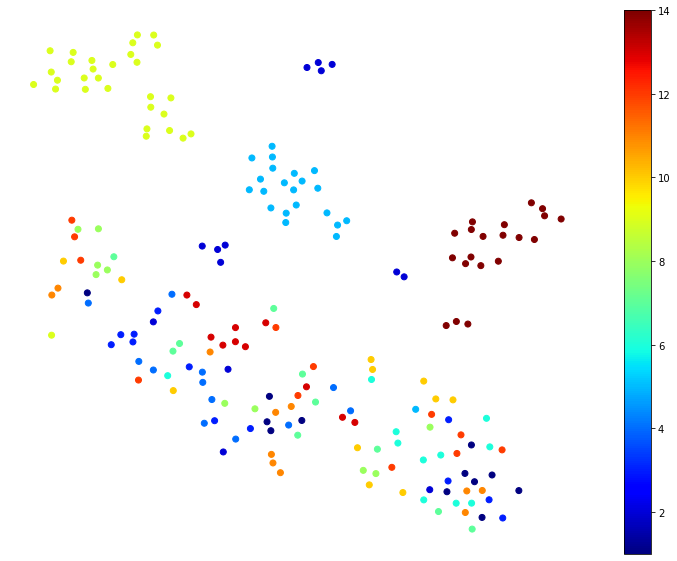

In [148]:
plt.figure(figsize=(13,10))
plt.scatter(new_X[:, 0], new_X[:, 1], c=y.flatten(), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# Example 3

In [149]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/log-regress/master/fashion.csv'
data = pd.read_csv(url)

In [150]:
data.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
y = data['label'].to_numpy()
X = data.iloc[:,1:].to_numpy()
X.shape

(10000, 784)

In [156]:
X = X/255
np.max(np.abs(X))

1.0

In [157]:
y

array([0, 1, 2, ..., 8, 8, 1], dtype=int64)

In [161]:
new_X = my_tsne(X[:2000], no_dims=2, initial_dims=50, perplexity=15, eta=500, max_iter = 1000)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.721161
Iteration 100: error is 15.156967
Iteration 200: error is 1.132764
Iteration 300: error is 1.011235
Iteration 400: error is 0.966993
Iteration 500: error is 0.943840
Iteration 600: error is 0.929678
Iteration 700: error is 0.920075
Iteration 800: error is 0.913186
Iteration 900: error is 0.907947
Iteration 1000: error is 0.903841


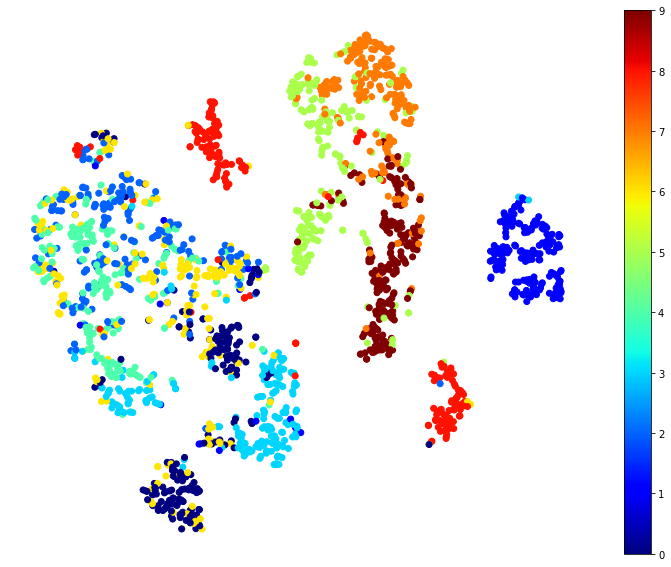

In [163]:
plt.figure(figsize=(13,10))
plt.scatter(new_X[:, 0], new_X[:, 1], c=y[:2000], cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()